In [2]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Test Env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 126.20it/s]


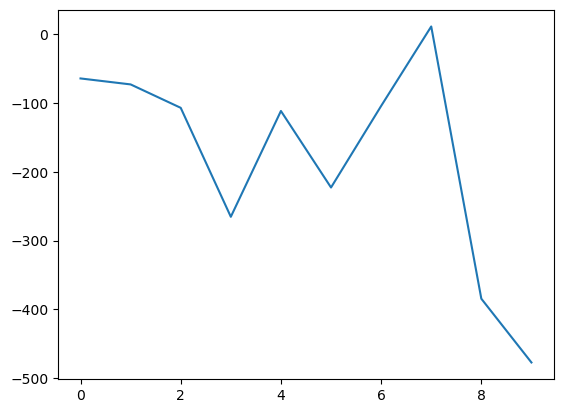

In [3]:
env = gym.make('LunarLander-v2')
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# DQN

In [15]:
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size = 64, lr = 5e-4, tau = 1e-3) -> None:
        super().__init__()

        self.tau = tau

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        self.criterion = nn.MSELoss()

    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)
    
    def optimize(self, input, target):
        loss = self.criterion(input, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def sync(self, other_net:nn.Module):
        self.load_state_dict(other_net.state_dict())
        #  for param, other_param in zip(self.parameters(), other_net.parameters()):
        #     param.data.copy_(self.tau*other_param.data + (1.0-self.tau)*param.data)


# Replay Memory

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append(Transition(state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        '''
        @params: 
            batch_size: int
        @return:
            states: torch.tensor
            actions: torch.tensor
            rewards: torch.tensor
            next_states: torch.tensor
            done: torch.tensor
        '''
        if batch_size > len(self.memory): return None
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.tensor(batch.state).float()
        next_state_batch = torch.tensor(batch.next_state).float()
        action_batch = torch.tensor(np.vstack(batch.action)).long()
        reward_batch = torch.tensor(np.vstack(batch.reward)).float()
        done_batch = torch.tensor(np.vstack(batch.done)).float()

        return (state_batch, action_batch, reward_batch, next_state_batch, done_batch)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [6]:
#Test memory
memory = ReplayMemory(capacity=10)
env = gym.make('LunarLander-v2')
obs, info = env.reset()
observation_n = len(obs)
action_n = env.action_space.n

for _ in range(10):
    state = env.observation_space.sample()
    next_state = env.observation_space.sample()
    action = env.action_space.sample()
    reward = random.randint(-100,100)
    done = random.choice([True,False])

    memory.push(state, action, reward, next_state, done)

states, actions, rewards, next_states, dones = memory.sample(5)
print(states)
print(actions)
print(rewards)
print(next_states)
print(dones)
env.close()

tensor([[ 1.4247e+00, -8.8455e-01,  4.4123e+00,  1.8001e+00,  7.8405e-01,
         -2.6001e-01,  9.6669e-01,  7.5462e-02],
        [-8.3875e-01,  1.4622e+00, -2.6239e+00,  1.5999e+00,  3.1128e+00,
         -2.1065e+00,  5.4083e-01,  3.1647e-02],
        [-3.4929e-01, -1.4587e+00, -2.5140e+00, -3.8912e+00, -1.8032e+00,
          1.4188e-04,  7.5671e-01,  1.1939e-01],
        [-1.2209e+00, -1.4385e+00, -2.3944e+00,  2.3847e-01,  1.2485e+00,
          3.4303e+00,  3.5710e-01,  9.5366e-01],
        [ 5.3094e-01, -1.8247e-02, -3.1169e+00,  4.6620e+00,  1.3209e+00,
         -2.7239e-01,  1.0388e-01,  1.0376e-01]])
tensor([[1],
        [1],
        [3],
        [0],
        [3]])
tensor([[-54.],
        [  4.],
        [ 48.],
        [  0.],
        [ 91.]])
tensor([[ 1.4249, -0.8572,  4.1832,  2.8110, -1.1213,  0.8193,  0.1510,  0.9966],
        [ 1.3989,  0.5107, -2.5068, -4.7784,  1.2421,  4.4000,  0.5525,  0.1565],
        [-1.0260,  0.5404, -0.4809, -4.7515,  2.0576,  2.4458,  0.7500,  

# Greedy Epsilon

In [7]:
def get_action(state, policy_net, eps, env):
    p = random.random()
    #exploit
    if p > eps:
        policy_net.eval()
        state = torch.tensor(state).float()
        with torch.no_grad():
            action = np.argmax(policy_net(state).numpy())
        policy_net.train()
        return action
    else:
        return env.action_space.sample()


In [8]:
env = gym.make('LunarLander-v2')
state, info = env.reset()
test_net = QNetwork(8,4)

exploit = get_action(state, test_net, 0.0, env)
print('exploit = ', exploit)

explore = get_action(state, test_net, 1.0, env)
print('explore = ', explore)
del test_net

exploit =  3
explore =  1


# Training loop

In [9]:
training_epochs = 1000
max_step = 1000
max_ep = 1.0
min_ep = 0.01
decay_ep =0.995
seed = 0

memory_cap = int(1e5)
batch_size = 64

lr = 5e-4
gamma = 0.99
tau = 1e-3
c = 4

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
epoch = 999, epsilon = 0.01, avg rewards=136.94: 100%|██████████| 1000/1000 [10:48<00:00,  1.54it/s]


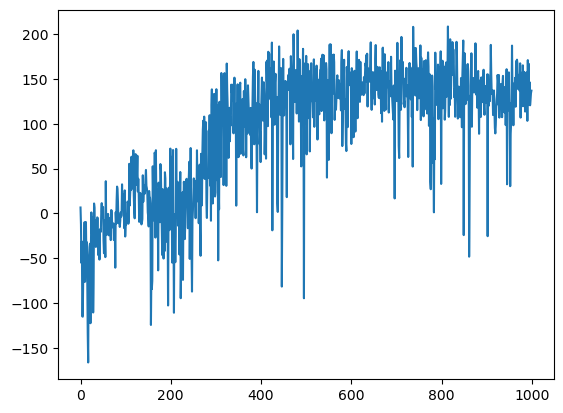

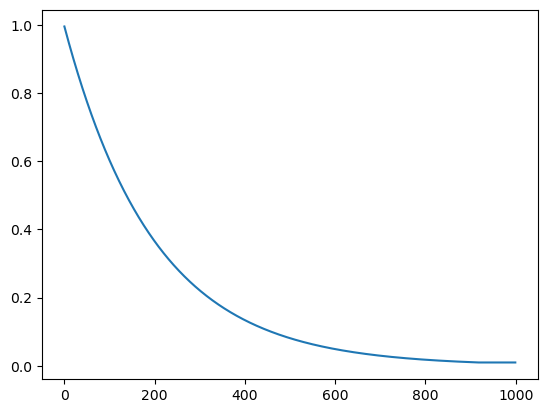

In [22]:
env = gym.make('LunarLander-v2')
obs,info = env.reset()
state_size = len(obs)
action_size = env.action_space.n

# agent = Agent(state_size, action_size)
policy_net = QNetwork(state_size, action_size)
target_net = QNetwork(state_size, action_size)

memory = ReplayMemory(capacity=memory_cap)

scores = []
score_window = deque(maxlen = 100)
epsilon = max_ep
step_count = 0
sync_count = 0

loop = tqdm(range(training_epochs))
history = defaultdict(list)

for epoch in loop:

    state, info = env.reset()
    total_reward = 0
    done = False
    epsilon = max(min_ep, epsilon *decay_ep)

    for t in count():

        step_count += 1

        action = get_action(state, policy_net, epsilon, env)
        next_state, reward, terminated, truncated, info = env.step(action)

        total_reward += reward
        score_window.append(total_reward)

        if terminated or truncated:
            done = True

        memory.push(state, action, reward, next_state, done)

        state = next_state

        transitions = memory.sample(batch_size)

        if transitions != None:
            states, actions, rewards, next_states, dones = transitions

            next_state_values = target_net(next_states).detach().max(1)[0].unsqueeze(1)
            ### Calculate target value from bellman equation
            next_state_values = rewards + gamma * next_state_values * (1 - dones)
            # print('q target = ', q_targets.shape)
            ### Calculate expected value from local network
            state_values = policy_net(states).gather(1, actions)

            policy_net.optimize(state_values, next_state_values)
            
            if step_count % c == 0:
                target_net.sync(policy_net)
                sync_count += 1
        if done:
            break

    loop.set_description(f'epoch = {epoch}, epsilon = {epsilon:.2f}, avg rewards={np.mean(score_window):.2f}')
    history['reward'].append(np.mean(score_window))
    history['epsilon'].append(epsilon)

sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))
plt.show()
sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))))
plt.show()

